# Creates plots for multiple steps

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_random_seed(13)

import py3nvml
py3nvml.grab_gpus(1)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passi

0

In [2]:
EARTHQUAKE_IDX = 1225

In [3]:
dataset = np.load('../data/acc/compressed/full_data.npy')
print("Before: ", dataset.shape)
#Swap axes
dataset = dataset.swapaxes(1, -1)

#Combine station and xyz
#dataset = dataset.reshape(dataset.shape[0], dataset.shape[1], -1)
print("After: ", dataset.shape)

Before:  (35679, 15, 60)
After:  (35679, 60, 15)


In [4]:
data_mean = np.mean(dataset, axis = 1)
data_var = np.linalg.norm(dataset - np.expand_dims(data_mean, 1), axis = 1)

#Add some epsilon to make the divide by zero var work
epsilon = 1
data_var[data_var == 0] = epsilon
data_var[data_var == 0] = epsilon

dataset = (dataset - np.expand_dims(data_mean, 1))/np.expand_dims(data_var, 1)

# Extract a quake

In [5]:
#Get a single quake
quake = dataset[EARTHQUAKE_IDX]
quake = quake.reshape((1, *quake.shape))
quake.shape

(1, 60, 15)

In [6]:
def multivariate_data(dataset, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    
    start_index = history_size
    end_index = dataset.shape[1] - target_size
        
    for quake in dataset:

        for i in range(start_index, end_index):
            indices = range(i-history_size, i, step)
            data.append(quake[indices])

            if single_step:
                labels.append(quake[i+target_size])
            else:
                labels.append(quake[i:i+target_size])

    return np.array(data), np.array(labels)

In [7]:
past_history = 15
future_target = 10
STEP = 1

x_train_multi, y_train_multi = multivariate_data(quake, past_history, future_target, STEP)

print(x_train_multi.shape, y_train_multi.shape)

(35, 15, 15) (35, 10, 15)


# Load the model

In [8]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(128,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'))
multi_step_model.add(tf.keras.layers.LSTM(64, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(150))

multi_step_model.load_weights("trained_models_acc/multistep/LSTM3_10steps.h5")

multi_step_model.compile(optimizer='adam', loss='mae', metrics= ['mse', 'mae'])
multi_step_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 128)           73728     
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 64)            49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 150)               9750      
Total params: 165,910
Trainable params: 165,910
Non-trainable params: 0
_________________________________________________________________


In [9]:
y_pred = multi_step_model.predict(x_train_multi)
y_pred = y_pred.reshape((y_pred.shape[0], 10, -1))
y_train_multi = y_train_multi.reshape((y_pred.shape[0], 10, -1))
y_pred.shape, y_train_multi.shape

((35, 10, 15), (35, 10, 15))

In [10]:
# def accumulate(y):
#     avg_pred = np.zeros((y.shape[0] + y.shape[1] - 1, 15))
#     for i, pred in enumerate(y):
#         avg_pred[i:i+5] += pred
#     for i in range(len(avg_pred)):
#         denom = min(5, i + 1, len(avg_pred) - i + 1)
#         avg_pred[i] = avg_pred[i]/denom
        
#     return avg_pred

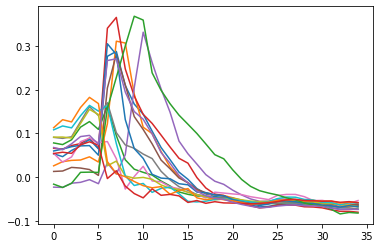

In [11]:
plt.plot(y_pred[:, -1, :])

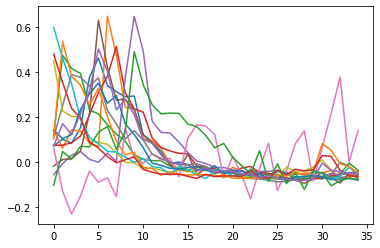

In [12]:
plt.plot(y_train_multi[:, -1, :])

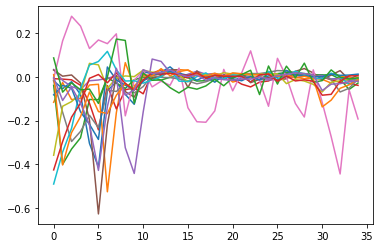

In [13]:
plt.plot(y_pred[:, -1, :] - y_train_multi[:, -1, :])

In [14]:
import sys
from os.path import dirname
sys.path.append(dirname("../"))

import numpy as np
import json

from utils.make_timeplot import multi_step_plot

In [21]:
dataset = np.load('../data/acc/compressed/full_data.npy')
metadata = None
with open('../data/acc/compressed/event_metadata.json','r') as fd:
    metadata = json.load(fd)

for i in range(y_pred.shape[1]):
    history = quake[0, :15 + i].swapaxes(0, 1)
    true_future = quake[0, 15 + i:].swapaxes(0, 1)
    epicenter = (metadata[EARTHQUAKE_IDX]['lat'], metadata[EARTHQUAKE_IDX]['lng'])
    pred = y_pred[:, i, :].swapaxes(0, 1)
    multi_step_plot(
        history, 
        true_future, 
        f"./multi_station_plots/tmp/{i + 1}_second_pred.png", 
        epicenter, 
        prediction = pred, 
        scale = 0.5, 
        title = f"{i} seconds forward"
    )

100%|██████████| 15/15 [00:00<00:00, 169.46it/s]


(35, 10, 15)


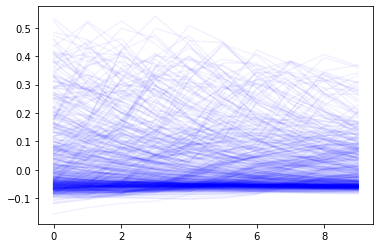

In [19]:
print(y_pred.shape)

for data in y_pred:
    plt.plot(data, alpha=0.05, color='blue')

In [22]:
from pathlib import Path
import imageio

images = []
for filename in sorted(Path('./multi_station_plots/tmp').glob("*_second_pred.png"), key=lambda i: int(os.path.splitext(os.path.basename(i))[0][0])):
    images.append(imageio.imread(filename))
    
with imageio.get_writer('./multi_station_plots/multi_timestep.gif', mode='I') as writer:
    for image in images:
        writer.append_data(image)

In [24]:
for i in range(y_pred.shape[0]):
    history = quake[0, :15 + i].swapaxes(0, 1)
    true_future = quake[0, 15 + i:].swapaxes(0, 1)
    epicenter = (metadata[EARTHQUAKE_IDX]['lat'], metadata[EARTHQUAKE_IDX]['lng'])
    pred = y_pred[i, :, :].swapaxes(0, 1)
    multi_step_plot(
        history, 
        true_future, 
        f"./multi_station_plots/tmp/{i + 1}_window_pred.png", 
        epicenter, 
        prediction = pred, 
        scale = 0.5, 
        title = f"{i} seconds forward"
    )

100%|██████████| 15/15 [00:00<00:00, 178.82it/s]


In [29]:
images = []
filenames = sorted(
    Path('./multi_station_plots/tmp').glob("*_window_pred.png"), 
    key=lambda i: int(os.path.splitext(os.path.basename(i))[0][0:os.path.splitext(os.path.basename(i))[0].find('_')])
)

for filename in filenames:
    images.append(imageio.imread(filename))
    
with imageio.get_writer('./multi_station_plots/multi_timestep_preds.gif', mode='I') as writer:
    for image in images:
        writer.append_data(image)